# Prepare data

In [9]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("train.csv", header = 0)

with pd.option_context('display.max_rows', 2, 'display.max_columns', 2):
    print(df)

X = [os.path.join(os.getcwd(), 'train', s) for s in df.Image]
y = df.Id.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train = X
y_train = y

classes = df.Id.unique()
num_classes = len(classes)

print('\nThere are %d total classes.' % num_classes)
print('There are %d total images.' % len(X))

print('There are %d training images.' % len(X_train))
print('There are %d validation images.' % len(X_valid))
print('There are %d test images.' % len(X_test))

             Image         Id
0     00022e1a.jpg  w_e15442c
...            ...        ...
9849  fffd4260.jpg  w_b9bfd4e

[9850 rows x 2 columns]

There are 4251 total classes.
There are 9850 total images.
There are 9850 training images.
There are 1576 validation images.
There are 1970 test images.


# Visualize the First 8 Training Images

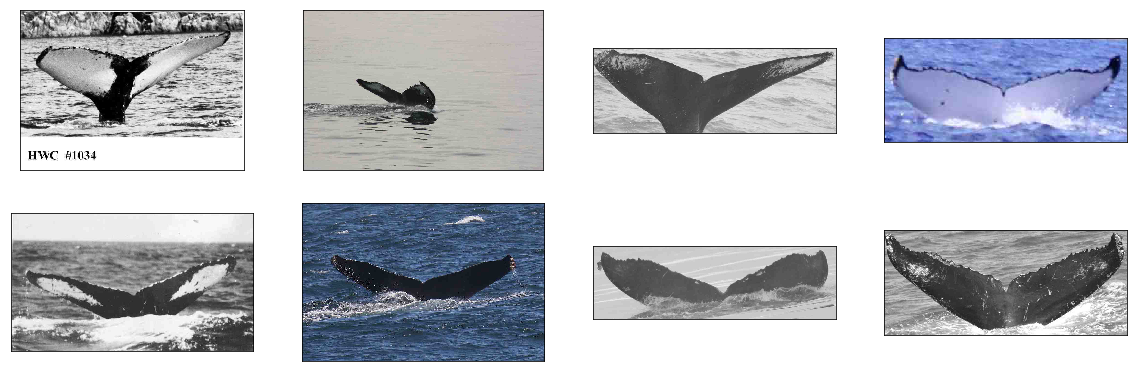

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(8):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(X_train[i], ax)

# Prepare Dataset for ImageDataGenerator

In [11]:
import shutil
import pathlib
import os

def copy_class_of_files(files, dst):
    for idx, val in enumerate(files):
        dst_dir = os.path.join(dst, y_train[idx])
        pathlib.Path(dst_dir).mkdir(parents=True, exist_ok=True)
        shutil.copy(val, dst_dir)
        
copy_class_of_files(X_train, 'data/train')
copy_class_of_files(X_valid, 'data/valid')
copy_class_of_files(X_test, 'data/test')

# Load CNN without top layer

In [12]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

# define InceptionResNetV2 model
image_side_size = 299
image_dim = (image_side_size, image_side_size, 3)
base_model = InceptionResNetV2(weights='imagenet', include_top=False,
                          input_tensor=None, input_shape = image_dim, 
                          pooling=None)
for layer in base_model.layers:
    layer.trainable = False
                      
# Train several last layers in base model
for layer in base_model.layers[-22:]:
    layer.trainable = True
    
#base_model.summary()

# Top layer specific to our problem

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

# Define image generators

In [15]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
target_size = (image_side_size, image_side_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size,
        shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
        'data/valid',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size)

Found 9850 images belonging to 4251 classes.
Found 3143 images belonging to 1928 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

best_weights_path='whale.flukes.weights.best.hdf5'

# train the model
checkpointer = ModelCheckpoint(filepath=best_weights_path, verbose=1, save_best_only=True)

# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='auto')

model.fit_generator(generator=train_generator,
                    epochs=100,
                    steps_per_epoch = int(len(X_train)/batch_size),
                    validation_data=valid_generator, 
                    validation_steps = int(len(X_valid)/batch_size),
                    callbacks=[checkpointer, stopper], verbose=1, workers=4)


Epoch 1/100
172/307 [===============>..............] - ETA: 37:57 - loss: 8.0499 - acc: 0.0850